In [1]:
import site
from pathlib import Path
site.addsitedir(str(Path.cwd().parents[2]))


import csv
from datetime import datetime
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

from presentation.gherqin.config import DEVICE, DTYPE
from presentation.gherqin.neural_states.positive_rbm import PositiveWaveFunction
from presentation.gherqin.neural_states.pauli import create_dict
from presentation.gherqin.data.tomography import ComputationalBasisDataset, RBMTomographyLoader

In [56]:
train_path = "w_vanilla_20_meas_50000.txt"
psi_path   = "w_vanilla_20_state.txt"

torch.manual_seed(1234)

data = ComputationalBasisDataset(train_path=train_path, psi_path=psi_path, device=DEVICE)

# run experiments and note down overlap one by one
# 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000
N_target = 50_000

N_use = min(N_target, len(data))
data.train_samples = data.train_samples[:N_use].contiguous()
data.train_bases   = data.train_bases[:N_use].copy()
data._z_mask       = data._z_mask[:N_use].clone()
data._z_indices    = torch.arange(N_use, dtype=torch.long)

nv = data.num_visible()
print(f"Using N={N_use} samples, n={nv} qubits, device={DEVICE}")

Using N=50000 samples, n=20 qubits, device=cpu


In [57]:
U = create_dict()
nh = nv * 3
nv, nh

(20, 60)

In [58]:
nn_state = PositiveWaveFunction(num_visible=nv, num_hidden=nh, unitary_dict=U, device=DEVICE)

epochs = 500
pos_batch_size = 100
neg_batch_size = pos_batch_size
lr = 0.1
k = 10
log_every = 10

loader = RBMTomographyLoader(data, pos_batch_size, neg_batch_size, device=DEVICE, dtype=DTYPE)

space = nn_state.generate_hilbert_space()
history = nn_state.fit(
    loader,
    epochs=epochs,
    k=k,
    lr=lr,
    log_every=log_every,
    target=data.target(),
    bases=data.eval_bases(),
    space=space,
    print_metrics=True,
    metric_fmt="Epoch {ep}: Fidelity = {fid:.6f} | KL = {kl:.6f}",
)

history.keys()

Epoch 10: Fidelity = 0.372447 | KL = 0.991673
Epoch 20: Fidelity = 0.381771 | KL = 0.967605
Epoch 30: Fidelity = 0.394107 | KL = 0.939233
Epoch 40: Fidelity = 0.425324 | KL = 0.862301
Epoch 50: Fidelity = 0.518325 | KL = 0.661594
Epoch 60: Fidelity = 0.704727 | KL = 0.356094
Epoch 70: Fidelity = 0.855346 | KL = 0.161322
Epoch 80: Fidelity = 0.920415 | KL = 0.087469
Epoch 90: Fidelity = 0.942944 | KL = 0.069188
Epoch 100: Fidelity = 0.963705 | KL = 0.039680
Epoch 110: Fidelity = 0.969221 | KL = 0.036572
Epoch 120: Fidelity = 0.972766 | KL = 0.034535
Epoch 130: Fidelity = 0.979570 | KL = 0.024528
Epoch 140: Fidelity = 0.977444 | KL = 0.031257
Epoch 150: Fidelity = 0.980637 | KL = 0.027182
Epoch 160: Fidelity = 0.977123 | KL = 0.035909
Epoch 170: Fidelity = 0.980745 | KL = 0.029801
Epoch 180: Fidelity = 0.985867 | KL = 0.019889
Epoch 190: Fidelity = 0.986200 | KL = 0.019643
Epoch 200: Fidelity = 0.988863 | KL = 0.015382
Epoch 210: Fidelity = 0.984875 | KL = 0.024260
Epoch 220: Fidelity = 

dict_keys(['epoch', 'Fidelity', 'KL'])

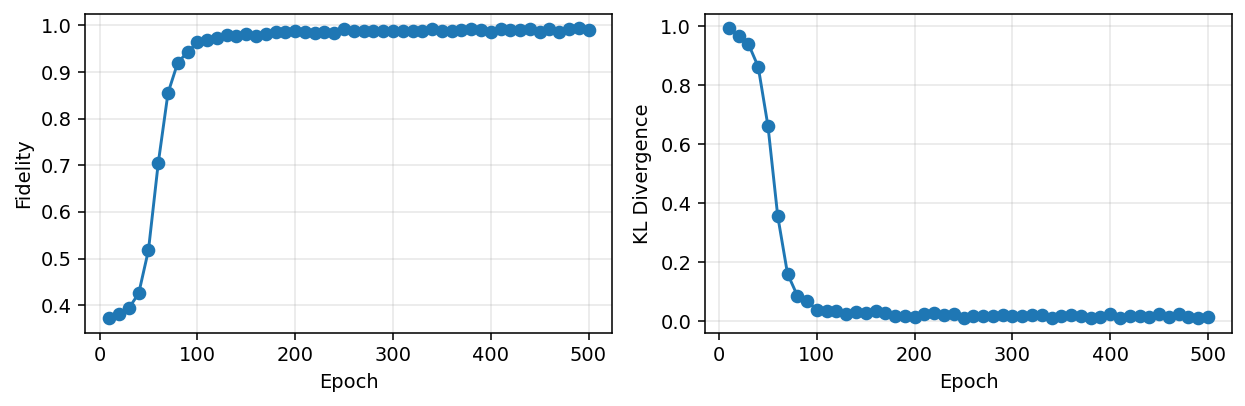

In [59]:
ep  = history.get("epoch", [])
fid = history.get("Fidelity", [])
kls = history.get("KL", [])

fig, axs = plt.subplots(1, 2, figsize=(9, 3.0), dpi=140)

axs[0].plot(ep, fid, 'o', linestyle="-")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Fidelity")

axs[1].plot(ep, kls, 'o', linestyle="-")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("KL Divergence")

for ax in axs: ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
@torch.no_grad()
def w_overlap_positive(model, M=10_000, k=100) -> float:
    """
    Heuristic W-overlap for PositiveWaveFunction using Gibbs sampling.
    For an n-qubit W state, measure consistency of the 1-hot manifold.
    """
    N = model.num_visible
    rbm = model.rbm
    device = model.device

    # Sample and filter to 1-hot
    initial = torch.bernoulli(torch.full((M, N), 0.5, device=device, dtype=DTYPE))
    samples = rbm.gibbs_steps(k=k, initial_state=initial)
    onehot_mask = samples.sum(dim=1) == 1
    onehot_samples = samples[onehot_mask]
    if onehot_samples.shape[0] == 0:
        return 0.0

    logp_sample = -rbm.effective_energy(onehot_samples)
    p_sample = torch.exp(logp_sample)
    term1 = torch.sum(1.0 / torch.sqrt(p_sample)).item() / M

    onehot_basis = torch.eye(N, dtype=DTYPE, device=device)
    logp_basis = -rbm.effective_energy(onehot_basis)
    p_basis = torch.exp(logp_basis)
    term2 = torch.sum(torch.sqrt(p_basis)).item() / N

    return float(np.sqrt(term1 * term2))

overlap = w_overlap_positive(nn_state)
print(f"Overlap: {overlap:.4f}")

Overlap: 1.0010


In [61]:
overlap_file = Path(f"overlap_{nv}.csv")

if not overlap_file.exists():
    with open(overlap_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "samples", "overlap"])

with open(overlap_file, "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([datetime.now().strftime("%Y-%m-%d %H:%M:%S"), N_target, overlap])

print(f"Logged overlap to {overlap_file}")

Logged overlap to overlap_20.csv
